In [1]:
# 代码运行说明： 
# 根据需求在本代码块中修改相应参数，就可Run All
# 结果会导出为两个自动命名的excel表格，分别是每月组合与每日收益
from WindPy import w
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
w.start()
w.isconnected()

# 一些设定值
buyRange = (1,3)  # 余额规模的买入区间。单位：亿元
rankNumber = 30  # 按序排列后的选取数量
sellThreshold = 0  # 转换价值的卖出门槛。0则不在月中卖出

# 考察时间范围：2018年1月至2021年12月的策略表现
beginDate = "2018-01-01"  # 考察范围内的起始日，必须填月首日
endDate = "2022-01-28"  # 考察范围内的最后一天（不必是最后一个交易日）

# 注意文件的日期
dataBase = pd.read_excel("./转债基础数据库/转债数据库(2022-01-28).xlsx")
dataBase

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


,code,name,listdate,delistdate
0,125009.SZ,宝安转债(退市),1993-02-10,1996-01-01
1,100001.SH,南化转债(退市),1998-09-02,2001-05-28
2,125301.SZ,丝绸转债(退市),1998-09-15,2003-08-27
3,125629.SZ,钢钒转债(退市),2003-02-17,2004-04-14
4,125002.SZ,万科转债(退市),2002-06-28,2004-04-30
...,...,...,...,...
688,113638.SH,台21转债,2022-01-21,NaT
689,123136.SZ,城市转债,NaT,NaT
690,113639.SH,华正转债,NaT,NaT
691,127053.SZ,豪美转债,NaT,NaT


In [2]:
# 选债日：select date
# 调仓日：change date
def get_dateNodes(beginDate,endDate):  # 获取选债与调仓的日期节点
    initialDate = datetime.datetime.strftime(w.tdaysoffset(-1, beginDate, "").Data[0][0],'%Y-%m-%d')  # 取开始日的上一个交易日
    selectDateSeries = w.tdays(initialDate, endDate, "Period=M").Data[0]  # 序列：每月最后一个交易日，是选债日
    changeDateSeries = []  # 序列：每月第一个交易日序列，是调仓日
    for date in selectDateSeries:  # 调仓日是对应选债日的下一个交易日
        changeDateSeries.append(w.tdaysoffset(1,date,Days = "Trading",Period = "D",TradingCalendar = "SSE").Data[0][0])
    return selectDateSeries,changeDateSeries

selectDateSeries,changeDateSeries = get_dateNodes(beginDate,endDate)
selectDateSeries, changeDateSeries

([datetime.datetime(2017, 12, 29, 0, 0),
  datetime.datetime(2018, 1, 31, 0, 0),
  datetime.datetime(2018, 2, 28, 0, 0),
  datetime.datetime(2018, 3, 30, 0, 0),
  datetime.datetime(2018, 4, 27, 0, 0),
  datetime.datetime(2018, 5, 31, 0, 0),
  datetime.datetime(2018, 6, 29, 0, 0),
  datetime.datetime(2018, 7, 31, 0, 0),
  datetime.datetime(2018, 8, 31, 0, 0),
  datetime.datetime(2018, 9, 28, 0, 0),
  datetime.datetime(2018, 10, 31, 0, 0),
  datetime.datetime(2018, 11, 30, 0, 0),
  datetime.datetime(2018, 12, 28, 0, 0),
  datetime.datetime(2019, 1, 31, 0, 0),
  datetime.datetime(2019, 2, 28, 0, 0),
  datetime.datetime(2019, 3, 29, 0, 0),
  datetime.datetime(2019, 4, 30, 0, 0),
  datetime.datetime(2019, 5, 31, 0, 0),
  datetime.datetime(2019, 6, 28, 0, 0),
  datetime.datetime(2019, 7, 31, 0, 0),
  datetime.datetime(2019, 8, 30, 0, 0),
  datetime.datetime(2019, 9, 30, 0, 0),
  datetime.datetime(2019, 10, 31, 0, 0),
  datetime.datetime(2019, 11, 29, 0, 0),
  datetime.datetime(2019, 12, 31, 

In [3]:
# 简单检查一下
len(selectDateSeries) == len(changeDateSeries)

True

In [4]:
# 需要获取市场信息的起始日
infoBeginDate = datetime.datetime.strftime(selectDateSeries[0],'%Y-%m-%d')
infoEndDate = endDate
print(infoBeginDate, infoEndDate)

2017-12-29 2022-01-28


In [5]:
#剔除掉绝对不在考虑范围内的可转债，最大程度地减少数据的提取
#剔除已经退市的债券，留下的就是在一定时间存在交易的和还没上市的
dataBase = dataBase[(dataBase.delistdate>datetime.datetime.strptime(infoBeginDate,'%Y-%m-%d')) | \
           (dataBase.delistdate.isnull())]
#剔除还没有上市时间的转债
dataBase = dataBase[(dataBase.listdate.notnull()) | \
                   (dataBase.listdate<=datetime.datetime.strptime(infoEndDate,'%Y-%m-%d'))]
dataBase.reset_index(inplace = True,drop = True)
dataBase

,code,name,listdate,delistdate
0,110039.SH,宝信转债(退市),2017-12-05,2018-07-13
1,123005.SZ,万信转债(退市),2018-01-30,2018-08-29
2,113010.SH,江南转债(退市),2016-04-05,2019-02-20
3,110032.SH,三一转债(退市),2016-01-18,2019-03-26
4,113512.SH,景旺转债(退市),2018-07-24,2019-04-30
...,...,...,...,...
550,123135.SZ,泰林转债,2022-01-19,NaT
551,113637.SH,华翔转债,2022-01-20,NaT
552,113052.SH,兴业转债,2022-01-14,NaT
553,118004.SH,博瑞转债,2022-01-27,NaT


In [6]:
# 取到考虑范围内全部可转债每个交易日的开盘价，收盘价，转换价值
codeList = dataBase["code"].tolist()
# 问题：以下四个连在一起跑就会出quota exceed
closeSeries = w.wsd(codeList, "close", infoBeginDate, infoEndDate,"PriceAdj=DP",usedf = True)[1]
openSeries = w.wsd(codeList, "open", infoBeginDate, infoEndDate,"PriceAdj=DP",usedf = True)[1]
#convvalueSeries = w.wsd(codeList, "convvalue", infoBeginDate, infoEndDate,"PriceAdj=DP",usedf = True)[1]
#turnSeries = w.wsd(codeList, "turn", infoBeginDate, infoEndDate,"PriceAdj=DP",usedf = True)[1]

In [7]:
closeSeries

,110039.SH,123005.SZ,113010.SH,110032.SH,113512.SH,113506.SH,123008.SZ,123006.SZ,113018.SH,113513.SH,...,123132.SZ,127052.SZ,123134.SZ,123133.SZ,110084.SH,123135.SZ,113637.SH,113052.SH,118004.SH,113638.SH
2017-12-29,106.70,100.0,104.13,121.71,NaN,NaN,NaN,100.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,107.17,100.0,103.93,126.64,NaN,NaN,NaN,100.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,108.00,100.0,103.57,127.53,NaN,NaN,NaN,100.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,110.35,100.0,103.34,127.07,NaN,NaN,NaN,100.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,112.95,100.0,103.80,130.14,NaN,NaN,NaN,100.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,133.804,135.000,133.300,127.783,117.66,132.000,131.29,116.50,100.00,136.54
2022-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,127.299,142.101,132.300,126.890,117.00,130.200,130.00,115.25,100.00,131.37
2022-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,128.460,141.574,132.380,127.440,116.96,130.701,131.61,115.49,100.00,132.89
2022-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,125.830,136.116,130.801,126.270,116.71,129.384,129.30,114.83,129.65,129.06


In [8]:
openSeries

,110039.SH,123005.SZ,113010.SH,110032.SH,113512.SH,113506.SH,123008.SZ,123006.SZ,113018.SH,113513.SH,...,123132.SZ,127052.SZ,123134.SZ,123133.SZ,110084.SH,123135.SZ,113637.SH,113052.SH,118004.SH,113638.SH
2017-12-29,106.40,100.0,103.59,122.00,NaN,NaN,NaN,100.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,106.60,100.0,103.92,122.60,NaN,NaN,NaN,100.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,107.00,100.0,104.19,126.77,NaN,NaN,NaN,100.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,108.22,100.0,103.54,127.25,NaN,NaN,NaN,100.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,110.40,100.0,103.37,127.09,NaN,NaN,NaN,100.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,133.784,130.000,133.55,128.489,117.60,135.775,128.60,115.49,100.00,129.60
2022-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,133.110,136.550,133.30,127.780,117.62,132.920,131.22,116.21,100.00,135.50
2022-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,127.289,142.101,132.90,126.890,116.95,131.603,129.05,115.18,100.00,130.03
2022-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,128.281,141.001,132.08,127.438,117.40,131.690,131.34,115.46,130.00,132.30


In [9]:
# 这部分需要手动去wind查看，首页—股票—新闻资讯—公司公告—高级—构造检索式即可
# 记得和可转债数据库一样需要更新
redeemBond = pd.read_excel("./特殊条款/强赎统计.xlsx",index_col=u"代码")
redeemIndex = redeemBond.index
resaleBond = pd.read_excel("./特殊条款/回售统计.xlsx",index_col=u"代码")
resaleIndex = resaleBond.index
repairBond = pd.read_excel("./特殊条款/董事会下修统计.xlsx",index_col=u"代码")
repairIndex = repairBond.index

In [10]:
# 构建投资组合函数
def construct_portfolio(valueRange, rankNumber, selectDateSeries, changeDateSeries, codeList):
    monthNums = len(selectDateSeries)
    portfolios = []
    
    for i in range(monthNums):
        selectDate = selectDateSeries[i]  # 开始建仓对比的上一个交易日收盘的信息，来确定下一期的组合
        changeDate = changeDateSeries[i]  # 建仓的月初早上
        print(selectDate,changeDate)
                
        # 获取决策当天所依据的信息，usedf = True传回pandas.DataFrame
        infoDF = w.wss(codeList, "convpremiumratio,ipo_date,lasttradingdate,\
                        maturitydate,rate_ratebond,outstandingbalance,convvalue,turn",\
                        "tradeDate={};priceAdj=DP;cycle=D;ratingAgency=101".format(selectDate),usedf = True)[1]
        
        infoDF = infoDF[infoDF["IPO_DATE"] <= selectDate]#剔除发行公告但是没上市的债券，剩余的均可交易
        infoDF = infoDF[infoDF["LASTTRADINGDATE"] >= changeDate]#剔除未上市的债券。保留第二日（下月初）仍可交易的股票
        
        """
        maturity = infoDF.loc[:,"MATURITYDATE"] - changeDate  # 离建仓换仓日还有一年到期的转债不参与入库
        maturityDays = []
        for day in maturity:
            maturityDays.append(day.days)  #.days可否直接用于tradingBond.loc[:,"MATURITYDATE"] - actionDay
        infoDF["剩余到期日"] = maturityDays
        infoDF = infoDF[infoDF["剩余到期日"]>=365]  # 可否先算出个今日一年后的日期，直接与MATURITYDATE列对比，不用新增剩余到期日

        
        #对评级和债券余额筛选：AA(含)以上，债券余额大于等于2E，到期日剩余大于一年
        boolS = infoDF["RATE_RATEBOND"].isin(["AAA","AAA-","AA+","AA"])
        infoDF = infoDF[boolS]
        infoDF = infoDF[infoDF["OUTSTANDINGBALANCE"]>=3] # 余额改为3E以上
        """
        
        # 小规模策略
        infoDF = infoDF[infoDF["OUTSTANDINGBALANCE"] >= valueRange[0]] # 余额改为1亿以上
        infoDF = infoDF[infoDF["OUTSTANDINGBALANCE"] <= valueRange[1]] # 余额改为3亿以下
        
        '''#　禁止爆炒规则
        for bond in infoDF.index:
            if signalTable.loc[selectDate,bond] == True:
                infoDF.drop(index=bond, inplace=True)'''
        
        sortedDF = infoDF.sort_values(by = "CONVPREMIUMRATIO" , ascending = True)
          
        portfolio = list(sortedDF.head(rankNumber).index)  # Wind传过来的index就是可转债代码
        portfolios.append(portfolio)
        
    # 输出结果
    dateColumns = []
    for date in changeDateSeries:
        dateColumns.append(datetime.datetime.strftime(date,"%Y-%m-%d"))
    
    portfoliosDF = pd.DataFrame(portfolios,index=dateColumns)
    portfoliosDF.T.to_excel("./小规模策略组合_{}-{}亿元_{}-{}.xlsx".format(valueRange[0],valueRange[1],beginDate,endDate))
        
    return portfolios

In [11]:
portfolios = construct_portfolio(buyRange, rankNumber, selectDateSeries, changeDateSeries, codeList)

2017-12-29 00:00:00 2018-01-02 00:00:00
2018-01-31 00:00:00 2018-02-01 00:00:00
2018-02-28 00:00:00 2018-03-01 00:00:00
2018-03-30 00:00:00 2018-04-02 00:00:00
2018-04-27 00:00:00 2018-05-02 00:00:00
2018-05-31 00:00:00 2018-06-01 00:00:00
2018-06-29 00:00:00 2018-07-02 00:00:00
2018-07-31 00:00:00 2018-08-01 00:00:00
2018-08-31 00:00:00 2018-09-03 00:00:00
2018-09-28 00:00:00 2018-10-08 00:00:00
2018-10-31 00:00:00 2018-11-01 00:00:00
2018-11-30 00:00:00 2018-12-03 00:00:00
2018-12-28 00:00:00 2019-01-02 00:00:00
2019-01-31 00:00:00 2019-02-01 00:00:00
2019-02-28 00:00:00 2019-03-01 00:00:00
2019-03-29 00:00:00 2019-04-01 00:00:00
2019-04-30 00:00:00 2019-05-06 00:00:00
2019-05-31 00:00:00 2019-06-03 00:00:00
2019-06-28 00:00:00 2019-07-01 00:00:00
2019-07-31 00:00:00 2019-08-01 00:00:00
2019-08-30 00:00:00 2019-09-02 00:00:00
2019-09-30 00:00:00 2019-10-08 00:00:00
2019-10-31 00:00:00 2019-11-01 00:00:00
2019-11-29 00:00:00 2019-12-02 00:00:00
2019-12-31 00:00:00 2020-01-02 00:00:00


In [12]:
computeDateSeries = selectDateSeries[1:-1]  # 收益计算日
computeDateSeries.append(datetime.datetime.strptime(endDate, "%Y-%m-%d"))  # 最后一个调仓日，难道作为整段时间的评判日？

In [13]:
def strategy_returns(sellThreshold, valueRange, selectDateSeries, changeDateSeries, computeDateSeries, portfolios):
    lastPortfolio = []#获取调仓时上一个周期的投资组合，刚开始空列表
    returnSeries = pd.DataFrame(columns = ["当日平均收益率"])

    for i in range(len(computeDateSeries)):
        selectDate = selectDateSeries[i].date()  # 举例，若decisionDay是2019年1月末
        changeDate = changeDateSeries[i].date()  # 则actionDay为2019年2月初
        computeDate = computeDateSeries[i].date()  # computeDay为2019年2月末

        newPortfolio = portfolios[i].copy()
        newBondSet = set(newPortfolio) - set(lastPortfolio)
        oldBondSet = set(newPortfolio) & set(lastPortfolio)
        
        newReturn = pd.DataFrame()
        oldReturn = pd.DataFrame()
        # 因为存在收盘价与次日开盘价的价差，所以调仓当天新债券与旧债券收益率计算不同，其他日期方式则一样
        if newBondSet:  # 如果有新增债券
            newCloseTable = closeSeries.loc[changeDate:computeDate,newBondSet]#获取新债券加入债券每个交易日的收盘价
            # 需要将每个周期第一天的收益率按照(当天收盘价/当天开盘价-1)计算
            # 其他交易日的收益率按照(当天收盘价/昨日收盘价-1)计算
            newFirstDayReturn = closeSeries.loc[changeDate,newBondSet] / openSeries.loc[changeDate,newBondSet] - 1
            newReturn = newReturn.append(newFirstDayReturn,ignore_index=True)
            # 为什么计算时要.reset_index(drop = True)？建议学习pandas运算的index对齐方式
            newReturn = newReturn.append((newCloseTable.iloc[1:,:].reset_index(drop = True)/ \
                         newCloseTable.iloc[:-1,:].reset_index(drop = True))-1)
        
        if oldBondSet:  # 如果投资组合里保留有上月的债券
            oldCloseTable = closeSeries.loc[selectDate:computeDate,oldBondSet]
            #如果债券不换仓，则每日收益率都按照(换仓日收盘价-看盘日收盘价)/看盘日收盘价
            oldReturn = oldReturn.append((oldCloseTable.iloc[1:,:].reset_index(drop = True)/ \
                         oldCloseTable.iloc[:-1,:].reset_index(drop = True))-1)
        
        #假设每期必有新券入库
        if newBondSet:  # 补回之前丢弃的index
            newReturn.index = newCloseTable.index
        if oldBondSet:
            oldReturn.index = oldCloseTable.iloc[1:].index
        
        allReturn = pd.concat([oldReturn, newReturn], axis=1)

        
        if sellThreshold != 0:
            # 判断非每月最后一个交易日转换价值是否高于sellThreshold（因为最后一个交易日另由月度调仓来分析）
            # 是则在当日以收盘价卖出（理想）
            # 首先要获取当前组合在本月的开盘价、收盘价数据
            closeTable = closeSeries.loc[changeDate:computeDate, newPortfolio]
            convvalueTable = convvalueSeries.loc[changeDate:computeDate, newPortfolio]
            for code in newPortfolio:
                closePrices = closeTable[code]
                convValues = convvalueTable[code]
                # 如果本月有转换价值高于sellThreshold的日期
                if not convValues[convValues > sellThreshold].empty: 
                    # 则在第一个这样的日期收盘时就卖出（理想状态）
                    # 将此后的收益率改为零
                    sellDay = convValues[convValues > sellThreshold].index[0]
                    allReturn.loc[sellDay+datetime.timedelta(1):, code] = 0

        #判断赎回
        periodRedeem = set(redeemIndex).intersection(set(newPortfolio))
        if periodRedeem:
            for code in periodRedeem:
                try:
                    dateList = redeemBond.loc[code,"日期"].tolist()
                except:
                    dateList = [redeemBond.loc[code,"日期"]]
                for d in dateList:
                    date = d.date()
                    if date >= changeDate and date <= computeDate:
                        allReturn.loc[date:,code] = 0 #强赎公告日的当天全天没有收益，也就是上一天收盘价就卖掉
                        print("{}赎回日:{}".format(code, date))
                    else:
                        continue

        #判断回售
        periodResale = set(resaleIndex).intersection(set(newPortfolio))
        if periodResale:
            for code in periodResale:
                try:
                    dateList = resaleBond.loc[code,"日期"].tolist()
                except:
                    dateList = [resaleBond.loc[code,"日期"]]
                for d in dateList:
                    date = d.date()
                    if date >= changeDate and date <= computeDate:
                        allReturn.loc[date:,code] = 0
                        print("{}回售日:{}".format(code,date))
                    else:
                        continue

        #判断下修
        periodRepair = set(repairIndex).intersection(set(newPortfolio))
        if periodRepair:
            for code in periodRepair:
                try:
                    dateList = repairBond.loc[code,"日期"].tolist()
                except:
                    dateList = [repairBond.loc[code,"日期"]]
                for d in dateList:
                    date = d.date()
                    if date >= changeDate and date <= computeDate:
                        allReturn.loc[date:,code] = 0
                        print("{}下修董事会召开日:{}".format(code,date))
                    else:
                        continue


        averReturn = pd.DataFrame(allReturn.mean(1),columns = ["当日平均收益率"])
        returnSeries = returnSeries.append(averReturn)
        
        lastPortfolio = newPortfolio
    
    # 计算累计平均收益率，然后输出为表格
    accuValue = 1
    accuReturnList = []
    for ret in returnSeries['当日平均收益率']:
        accuValue = (1 + ret) * accuValue
        accuReturnList.append(accuValue - 1)
    accuReturnSeries = pd.DataFrame({"累计平均收益率":accuReturnList}, index = returnSeries.index)
        
    returnTable = pd.concat([returnSeries,accuReturnSeries], axis=1)
    
    returnTable.to_excel("./小规模策略收益_{}-{}亿元-{}_{}-{}.xlsx".format(valueRange[0],valueRange[1],sellThreshold,beginDate,endDate))
        
    return returnTable

In [14]:
returnTable = strategy_returns(sellThreshold,buyRange,selectDateSeries,changeDateSeries,computeDateSeries,portfolios)

128043.SZ下修董事会召开日:2018-11-05
123008.SZ赎回日:2019-03-25
113506.SH赎回日:2019-04-05
113513.SH赎回日:2019-06-11
128051.SZ下修董事会召开日:2019-07-09
127009.SZ赎回日:2019-08-29
123001.SZ赎回日:2019-09-11
128030.SZ回售日:2019-12-20
113523.SH赎回日:2020-01-16
113533.SH赎回日:2020-01-06
113539.SH赎回日:2020-02-24
128038.SZ赎回日:2020-02-25
113511.SH赎回日:2020-04-09
128054.SZ赎回日:2020-06-08
113552.SH赎回日:2020-07-13
123026.SZ赎回日:2020-10-28
113555.SH赎回日:2020-11-10
128058.SZ赎回日:2020-11-04
113553.SH赎回日:2020-11-06
113581.SH赎回日:2020-11-19
128065.SZ赎回日:2021-01-25
128110.SZ赎回日:2021-01-07
113587.SH赎回日:2021-01-12
113586.SH赎回日:2021-01-06
113564.SH赎回日:2021-04-14
113559.SH赎回日:2021-06-03
128051.SZ赎回日:2021-07-28
113572.SH赎回日:2021-08-29
123047.SZ赎回日:2021-10-20
123028.SZ赎回日:2021-11-24
113536.SH赎回日:2021-12-14
123081.SZ赎回日:2021-12-17


In [15]:
returnTable

,当日平均收益率,累计平均收益率
2018-01-02,0.002499,0.002499
2018-01-03,0.008516,0.011036
2018-01-04,0.000515,0.011556
2018-01-05,0.015953,0.027694
2018-01-08,0.000000,0.027694
...,...,...
2022-01-24,0.008049,2.633520
2022-01-25,-0.024783,2.543470
2022-01-26,0.003671,2.556479
2022-01-27,-0.017197,2.495318


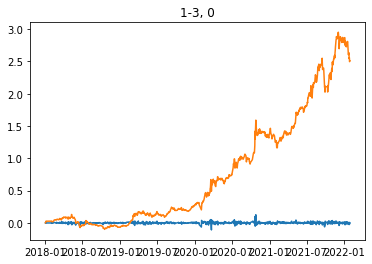

In [16]:
plt.title("{}-{}, {}".format(buyRange[0],buyRange[1],sellThreshold))
plt.plot(returnTable)